In [39]:
from math import exp, sqrt

class Stock:
    def __init__(self, spot, vol):
        self.spot = spot
        self.vol = vol

class Option:
    def __init__(self, underlying, expiry):
        self.underlying = underlying
        self.expiry = expiry

    def final_payoff(self, spot):
        raise NotImplementedError("Final option payoff is not defined")

    def early_payoff(self, spot):
        raise NotImplementedError("Early exercise payoff is not defined")

class BinomialModel:
    def __init__(self, option, r):
        self.option = option
        self.r = r

    def price(self, N=500):
        dt = self.option.expiry/N   # Step size
        u =  exp(self.option.underlying.vol * sqrt(dt)) # Up movment
        d = 1/u
        p = (exp(self.r * dt) - d)/(u - d) # Risk-neutral probability

        def S(k,m):
            return self.option.underlying.spot * (u ** (2*m-k))

        C = {}

        for m in range(0, N+1):
            C[(N, m)] = self.option.final_payoff(S(N,m))

        for k in range(N-1, -1, -1):
            for m in range(0,k+1):
                future_value = exp(-self.r * dt) * (p * C[(k+1, m+1)] + (1-p) * C[(k+1, m)])
                exercise_value = self.option.early_payoff(S(k,m))
                C[(k, m)] = max(future_value, exercise_value)
        return C[(0,0)]

class EuroCall(Option):
    def __init__(self, underlying, expiry, strike):
        """
        strike: a float, the strike price of the asset
        """
        super().__init__(underlying, expiry)
        self.strike = strike

    def final_payoff(self, spot):
        # Standard payoff function for a call option
        return max(spot - self.strike,0)

    def early_payoff(self, spot):
        # Returns zero since European call options cannot be exercised early
        return 0

class EuroPut(Option):
    def __init__(self, underlying, expiry, strike):
        super().__init__(underlying, expiry)
        self.strike = strike

    def final_payoff(self, spot):
        # Standard payoff for a put option
        return max(self.strike - spot,0)

    def early_payoff(self, spot):
        # Returns zero since European put options cannot be exercised early
        return 0

class AmerCall(EuroCall):
    def early_payoff(self, spot):
        # American options can be exercised early with the same payoff
        # as at expiration
        return self.final_payoff(spot)

class AmerPut(EuroPut):
    def early_payoff(self, spot):
        # American options can be exercised early with the same payoff
        # as at expiration
        return self.final_payoff(spot)


In [40]:
import matplotlib.pyplot as plt
import numpy as np

def plot_option_price(option, title):
    x_points = []
    y_points = []
    for i in range(100, 1001, 100):
        x_points.append(i)
        y_points.append(BinomialModel(option, 0.02).price(i))
    plt.plot(np.array(x_points), np.array(y_points))
    plt.title(title)
    plt.show()


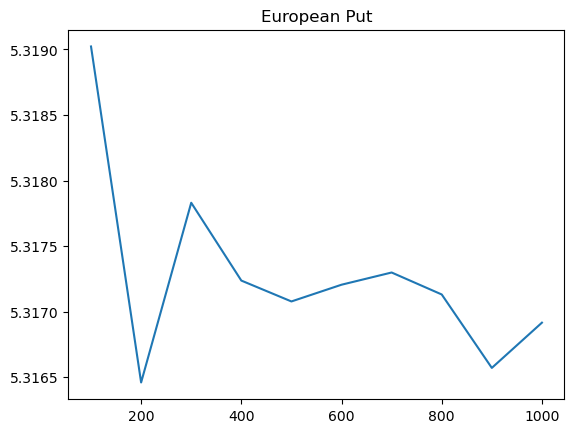

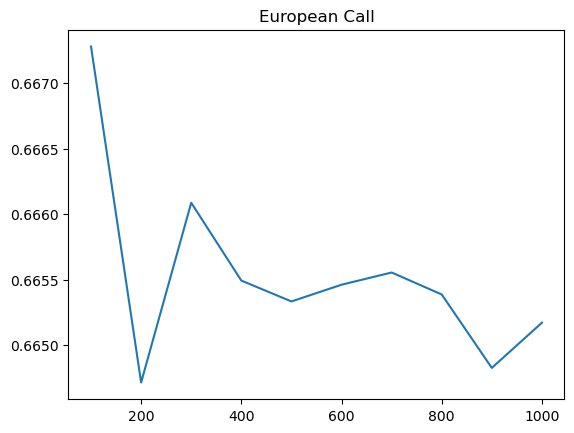

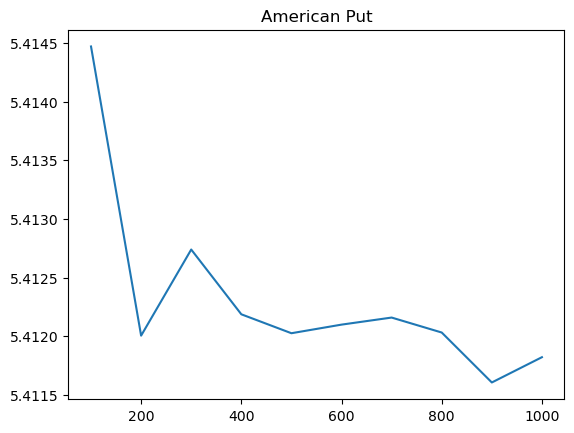

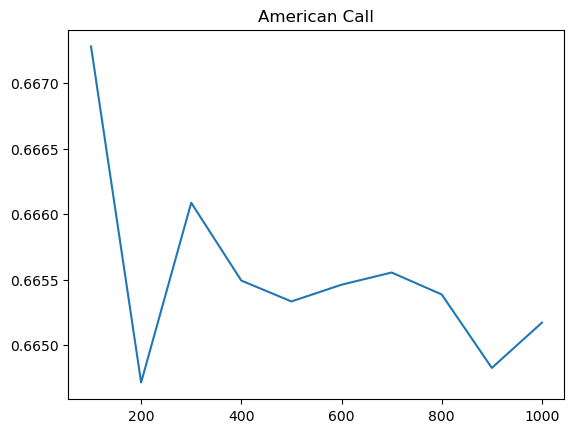

In [41]:
S = 30  # initial stock price
K = 35  # strike price
r = 0.02  # risk-free interest rate
sigma = 0.25  # stock price volatility
T = 0.5  # time to maturity (in years)
stock = Stock(S, sigma)

# European Put
option = EuroPut(stock, T, K)
plot_option_price(option, "European Put")

# European Call
option = EuroCall(stock, T, K)
plot_option_price(option, "European Call")

# American Put
option = AmerPut(stock, T, K)
plot_option_price(option, "American Put")

# American Call
option = AmerCall(stock, T, K)
plot_option_price(option, "American Call")